In [23]:
# 1.Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [24]:
# 2. Load your dataset
df = pd.read_csv('Data/Transactions.csv')
df.head()

,Transaction_ID,Type,Transaction_Type,Customer_Name,Total,Success,Day,Transaction_Notes,Source,Country,Auth_code
0,1234567,Charge,Goods and Services,James,3286,1,1/2/2023,Thanks,Tablet,US,X8JZG7YH
1,9876543,Refund,Friends & Family,Emily,1624,1,1/3/2023,Raffle,Phone,US,D2F3R6KP
2,4567890,Charge,Goods and Services,Liam,2659,1,1/4/2023,Thanks,Desktop,US,Q9L4T1VW
3,7654321,Charge,Goods and Services,Olivia,4897,1,1/5/2023,Thanks,Phone,US,M7N5P0QI
4,2345678,Charge,Friends & Family,Benjamin,3643,1,1/6/2023,Thanks,Desktop,UK,B6K8D3XJ


In [25]:
# 3. Drop irrelevant columns
df = df.drop(columns=["Customer_Name", "Auth_code", "Transaction_Notes","Transaction_ID"])

In [26]:
# 4. Separate features and target
X = df.drop("Success", axis=1)
y = df["Success"]

In [27]:
# 5. Encode categorical features
categorical_cols = X.select_dtypes(include=["object"]).columns
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_encoded = pd.DataFrame(
	encoder.fit_transform(X[categorical_cols]),
	columns=encoder.get_feature_names_out(categorical_cols)
)
X = X.drop(columns=categorical_cols)
X = pd.concat([X.reset_index(drop=True), X_encoded.reset_index(drop=True)], axis=1)

In [28]:
# 6. Scale numerical features & Create Column Transformer
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)
X_scaled = preprocessor.fit_transform(X)

In [29]:
# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((160, 191), (40, 191))

- Handle Imbalanced Data

In [30]:
# 8. Apply SMOTE to training data only

# Find the number of samples in the minority class
min_class_count = y_train.value_counts().min()

# Set k_neighbors to at most min_class_count - 1 (minimum allowed is 1)
k_neighbors = max(1, min_class_count - 1)

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [31]:
# 9. Model Evaluation
def evaluate_model(true, predicted, probs=None):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

    acc = accuracy_score(true, predicted)
    # use binary average when appropriate, otherwise fallback to macro
    avg = "binary" if len(set(true)) == 2 else "macro"
    prec = precision_score(true, predicted, average=avg, zero_division=0)
    rec = recall_score(true, predicted, average=avg, zero_division=0)
    f1 = f1_score(true, predicted, average=avg, zero_division=0)

    roc = None
    if probs is not None:
        try:
            roc = roc_auc_score(true, probs)
        except Exception:
            roc = None

    cm = confusion_matrix(true, predicted)
    return acc, prec, rec, f1, roc, cm

In [37]:
# 10. Classification model loop
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVC": SVC(probability=True, class_weight='balanced', random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_resampled, y_resampled)

    y_train_pred = model.predict(X_resampled)
    y_test_pred = model.predict(X_test)

    try:
        y_test_proba = model.predict_proba(X_test)[:, 1]
    except:
        try:
            y_test_proba = model.decision_function(X_test)
        except:
            y_test_proba = None

    train_acc, train_prec, train_rec, train_f1, train_roc, _ = evaluate_model(y_resampled, y_train_pred, None)
    test_acc, test_prec, test_rec, test_f1, test_roc, test_cm = evaluate_model(y_test, y_test_pred, y_test_proba)

    results.append({
        "Model": name,
        "Train Accuracy": round(train_acc, 4),
        "Test Accuracy": round(test_acc, 4),
        "Test Precision": round(test_prec, 4),
        "Test Recall": round(test_rec, 4),
        "Test F1 Score": round(test_f1, 4),
        "Test ROC AUC": round(test_roc, 4) if test_roc is not None else "N/A"
    })

# Create and display the DataFrame
model_df = pd.DataFrame(results)
model_df = model_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)
model_df

,Model,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test ROC AUC
0,Logistic Regression,1.0000,0.95,0.95,1.0,0.9744,0.4605
1,K-Nearest Neighbors,0.9968,0.95,0.95,1.0,0.9744,0.5000
2,Decision Tree,1.0000,0.95,0.95,1.0,0.9744,0.5000
3,Random Forest,1.0000,0.95,0.95,1.0,0.9744,0.8684
4,XGBoost,1.0000,0.95,0.95,1.0,0.9744,0.8289
5,AdaBoost,1.0000,0.95,0.95,1.0,0.9744,0.2368
6,SVC,0.9968,0.95,0.95,1.0,0.9744,0.5132


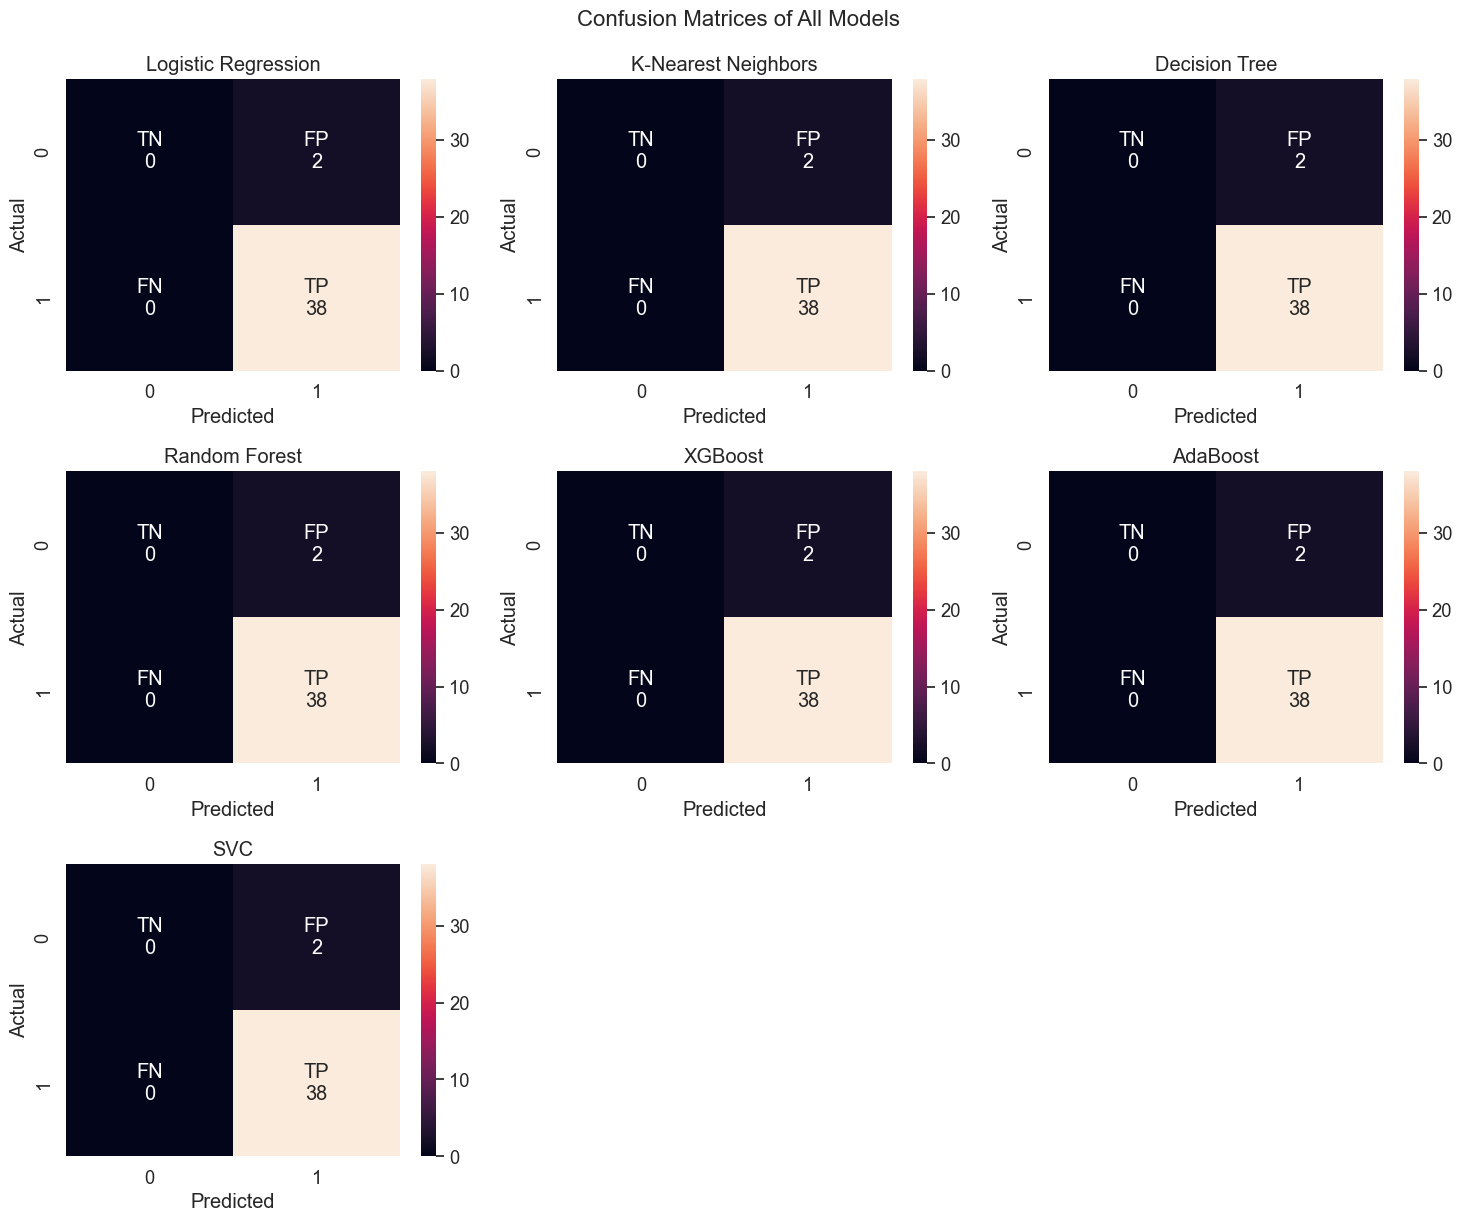

In [59]:
# 11. Plot confusion matrices for all models
def plot_all_confusion_matrices(models, X_test, y_test):
    n_models = len(models)
    cols = 3  # Number of columns in the grid
    rows = (n_models + cols - 1) // cols  # Calculate rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        # Annotate with TP, TN, FP, FN if binary classification
        if cm.shape == (2, 2):
            labels = np.array([["TN", "FP"], ["FN", "TP"]])
            annot = np.array([[f"{labels[i][j]}\n{cm[i][j]}" for j in range(2)] for i in range(2)])
            sns.heatmap(cm, annot=annot, fmt='', ax=axes[idx])
        else:
            # For multiclass, just show numbers
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx])

        axes[idx].set_title(name)
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("Confusion Matrices of All Models", fontsize=16, y=1.02)
    plt.show()
plot_all_confusion_matrices(models, X_test, y_test)

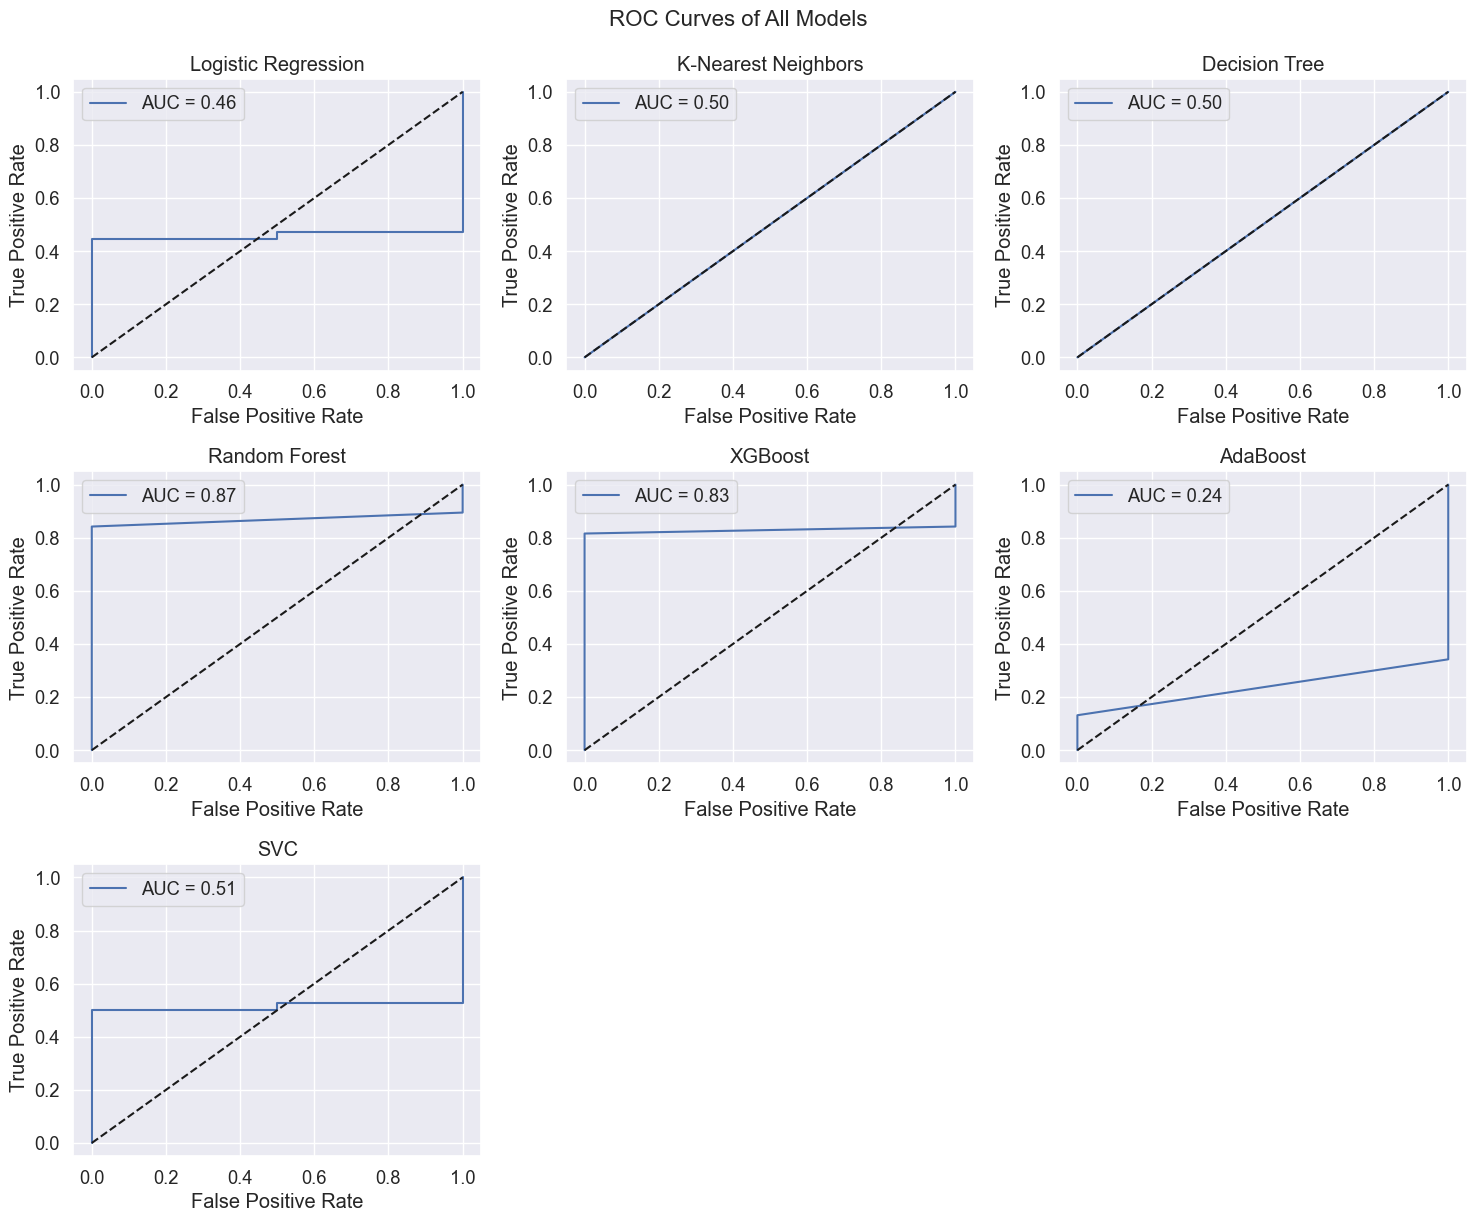

In [60]:
# 12. Plot all AUC-ROC curves
from sklearn.metrics import roc_curve, auc
def plot_all_roc_curves(models, X_test, y_test):
    n_models = len(models)
    cols = 3  # Number of columns in the grid
    rows = (n_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models.items()):
        try:
            # Get probability scores
            y_proba = model.predict_proba(X_test)[:, 1]
        except:
            try:
                y_proba = model.decision_function(X_test)
            except:
                y_proba = None

        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            axes[idx].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
            axes[idx].plot([0, 1], [0, 1], 'k--')
            axes[idx].set_title(name)
            axes[idx].set_xlabel('False Positive Rate')
            axes[idx].set_ylabel('True Positive Rate')
            axes[idx].legend()
        else:
            axes[idx].text(0.5, 0.5, 'No ROC available', ha='center', va='center')
            axes[idx].set_title(name)
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])

    # Hide unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("ROC Curves of All Models", fontsize=16, y=1.02)
    plt.show()
plot_all_roc_curves(models, X_test, y_test)

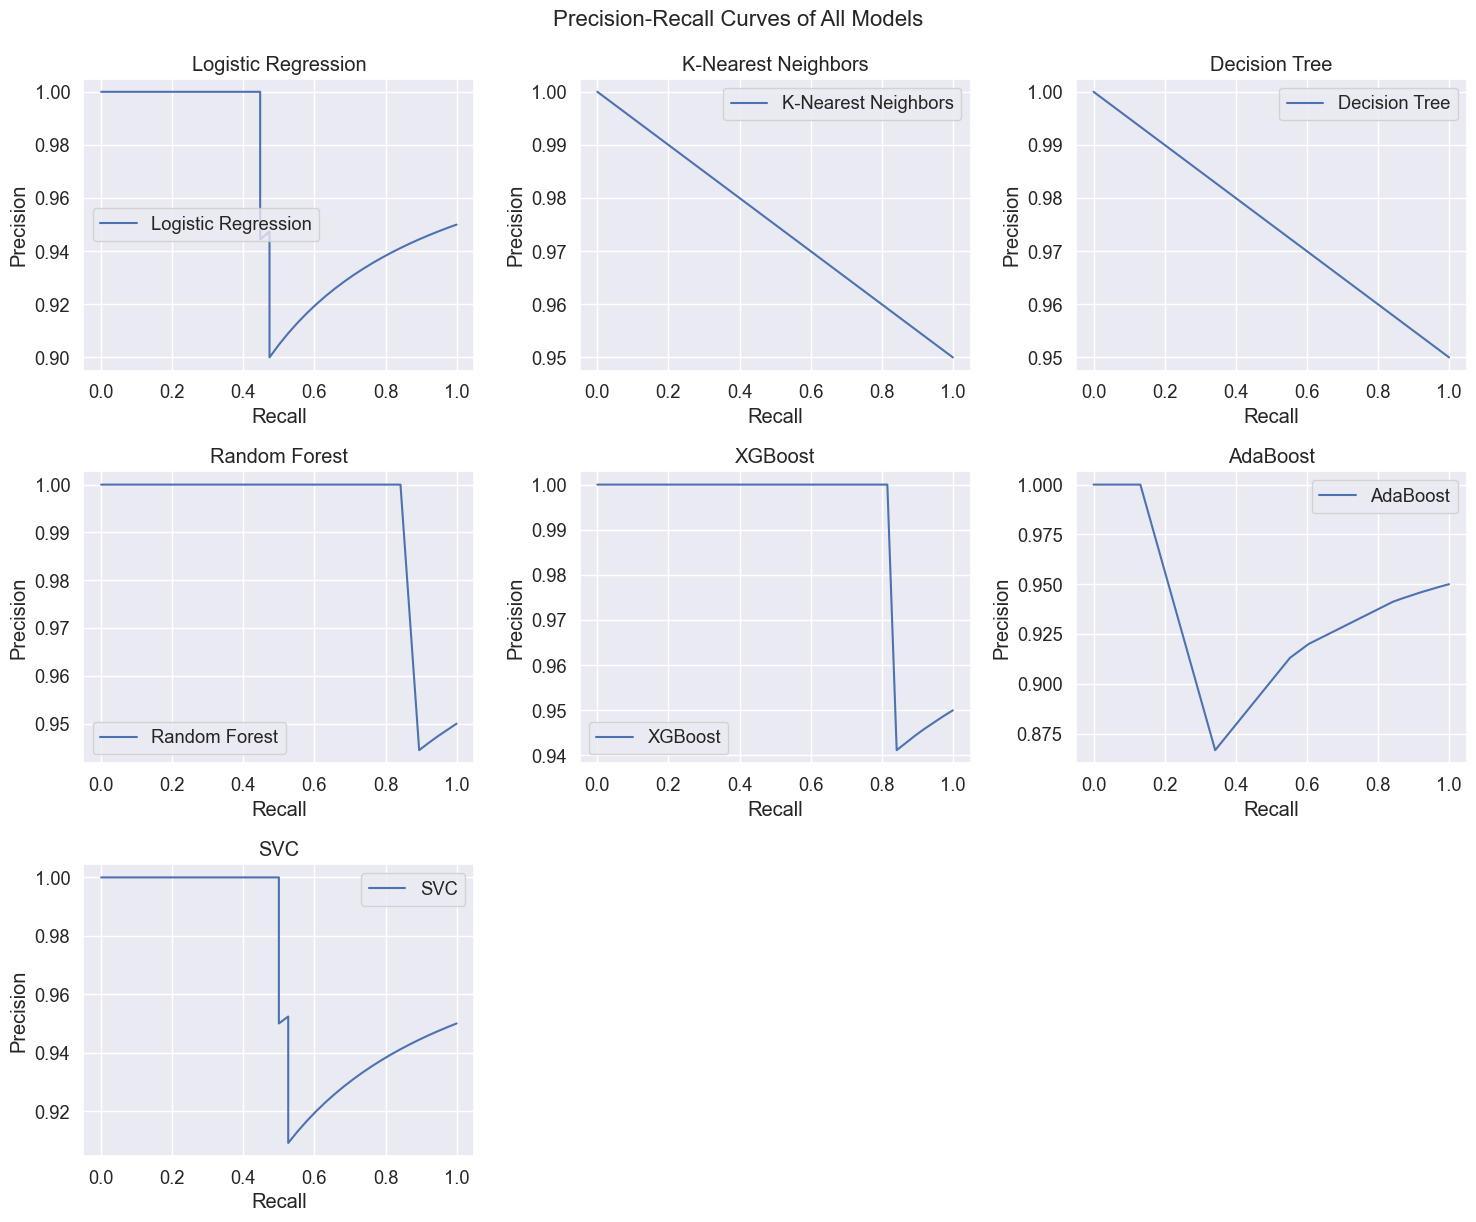

In [61]:
# 13. Plot all Precision-Recall curves
from sklearn.metrics import precision_recall_curve

def plot_all_pr_curves(models, X_test, y_test):
    n_models = len(models)
    cols = 3  # Number of columns in the grid
    rows = (n_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models.items()):
        try:
            # Get probability scores
            y_proba = model.predict_proba(X_test)[:, 1]
        except:
            try:
                y_proba = model.decision_function(X_test)
            except:
                y_proba = None

        if y_proba is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            axes[idx].plot(recall, precision, label=name)
            axes[idx].set_title(name)
            axes[idx].set_xlabel('Recall')
            axes[idx].set_ylabel('Precision')
            axes[idx].legend()
        else:
            axes[idx].text(0.5, 0.5, 'No PR curve available', ha='center', va='center')
            axes[idx].set_title(name)
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])

    # Hide unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("Precision-Recall Curves of All Models", fontsize=16, y=1.02)
    plt.show()
plot_all_pr_curves(models, X_test, y_test)

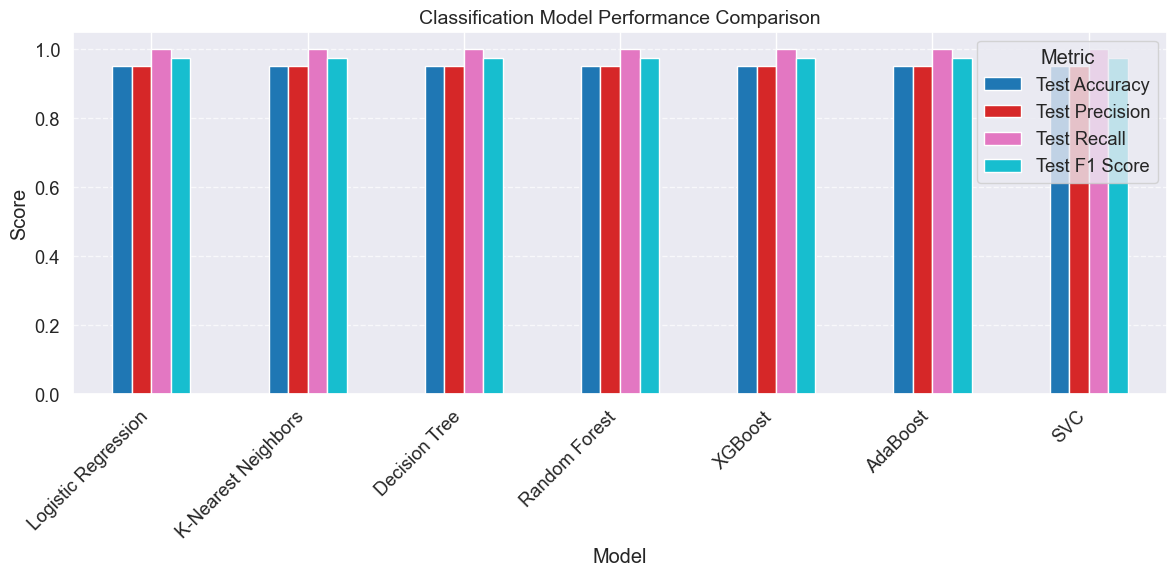

In [62]:
# 14. Plot model metrics bar chart
def plot_model_metrics_bar_chart(model_df):
    metrics_to_plot = ["Test Accuracy", "Test Precision", "Test Recall", "Test F1 Score"]

    # Set model names as index
    df_plot = model_df.set_index("Model")[metrics_to_plot]

    # Plot grouped bar chart
    ax = df_plot.plot(kind='bar', figsize=(12, 6), colormap='tab10')
    plt.title("Classification Model Performance Comparison", fontsize=14)
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Metric", loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
plot_model_metrics_bar_chart(model_df)

In [63]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_test_pred,'Difference':y_test-y_test_pred})
pred_df.head()

,Actual Value,Predicted Value,Difference
95,1,1,0
15,1,1,0
30,1,1,0
158,1,1,0
128,1,1,0
